# GLOBAL SUPERSTORE DATASET SALES ANALYSIS
By Raju Vaneshwar Nareshwar

## Table of contents
1. [Task 1](#task1)

    1.1 [Load first 10 records](#load-first-10-records)
    
    1.2 [Understanding the dataset](#understanding-dataset)

2. [Assess the data](#assess)

    2.1 [Meta Data](#metadata)
    
    2.2 [Assessment Summary](#summary)

3. [Data Cleaning](#clean)

4. [Analysis and Data Visualization](#analysis)

    4.1 [Product Analysis](#product)

    4.2 [Segment Analysis](#segment)

    4.3 [Geographical market location Analysis](#market)

    4.4 [Shipping](#shipping)

    4.5 [Time Series Analysis](#time)

5. [Insights](#insights)

    5.1 [Findings](#findings)

    5.2 [Limitations](#limitation)

    5.3 [Recommendations](#recommendation)

## 1. Task 1  <a id='task1'></a>

### 1.1 Load first 10 records <a id='load-first-10-records'></a>

In [162]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker as mtick
import seaborn as sns

# Letting pandas to show max columns
pd.set_option('display.max_columns', None)

In [163]:
# Reading CSV file and assigning into a dataframe ss_data
global_super_store_data = pd.read_csv('sample-superstore-2023-T3.csv')

# Set the head to 10 to retrieve the first 10 records
first_10_rows = global_super_store_data.head(n=10)
first_10_rows

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7773,CA-2016-108196,25/11/2016,12/02/2016,Standard Class,CS-12505,Cindy Stewart,Consumer,United States,Lancaster,Ohio,43130,Est,TEC-MA-10000418,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5,0.7,-6599.978
1,684,US-2017-168116,11/04/2017,11/04/2017,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,North Carolina,"""27217""",South,TEC-MA-10004125,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904
2,9775,CA-2014-169019,26/07/2014,30/07/2014,Standard Class,LF-17185,Luke Foster,Consumer,United States,San Antonio,Texas,78207,Central,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8,0.8,-3701.8928
3,3012,CA-2017-134845,17/04/2017,24/04/2017,Standard Class,SR-20425,Sharelle Roach,Home Office,United States,Louisville,Colorado,80027,West,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.98
4,4992,US-2017-122714,12/07/2017,13/12/2017,Standard Class,HG-14965,Henry Goldwyn,Corporate,United States,Chicago,Illinois,60653,Central,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,1889.990,5,0.8,-2929.4845
5,3152,CA-2015-147830,15/12/2015,18/12/2015,First Class,NF-18385,Natalie Fritzler,Consumer,United States,Newark,Ohio,43055,East,TEC-MA-10000418,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,1799.994,Two,0.7,"""-2639.9912"""
6,5311,CA-2017-131254,19/11/2017,21/11/2017,First Class,NC-18415,Nathan Cano,Consumer,United States,Houston,Texas,77095,Central,OFF-BI-10003527,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,1525.188,6,0.8,-2287.782
7,9640,CA-2015-116638,28/01/2015,NaN,Second Class,JH-15985,Joseph Holt,Consumer,United States,Concord,North Carolina,28027,South,FUR-TA-10000198,Frnture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,Thirteen,0.4,NaN
8,1200,CA-2016-130946,04/08/2016,04/12/2016,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,Texas,77041,Central,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,1088.792,4,0.8,-1850.9464
9,2698,CA-2014-145317,18/03/2014,23/03/2014,Standard Class,SM-20320,Sean Miller,Home Office,NaN,Jacksonville,Florida,32216,Southh,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784


### 1.2 Understanding of the dataset <a id='understanding-dataset'></a>

Using info() and describe() function to get the descriptive statistics

In [164]:
# Get the metadata information about the dataset
global_super_store_data.info()

# Get descriptive statistics on the dataset
global_super_store_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9993 non-null   object 
 2   Order Date     9992 non-null   object 
 3   Ship Date      9991 non-null   object 
 4   Ship Mode      9990 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9991 non-null   object 
 7   Segment        9991 non-null   object 
 8   Country        9990 non-null   object 
 9   City           9992 non-null   object 
 10  State          9990 non-null   object 
 11  Postal Code    9991 non-null   object 
 12  Region         9991 non-null   object 
 13  Product ID     9992 non-null   object 
 14  Category       9992 non-null   object 
 15  Sub-Category   9990 non-null   object 
 16  Product Name   9991 non-null   object 
 17  Sales          9993 non-null   float64
 18  Quantity

,Row ID,Sales,Discount
count,9994.000000,9993.000000,9991.000000
mean,4997.500000,229.863780,0.156180
std,2885.163629,623.276019,0.206399
min,1.000000,0.444000,0.000000
25%,2499.250000,17.280000,0.000000
50%,4997.500000,54.480000,0.200000
75%,7495.750000,209.940000,0.200000
max,9994.000000,22638.480000,0.800000


The primary key of these records are a system-generated, and denoted as column: *RowID*

The datatypes of the dataset are following:
* int64(1)
* float64(2)
* object(18)

A few records of *Quantity* and *Profit* columns has the datatype of object, but it must be float64, thus needs to be cleansed or transformed.  
*Ship Date* and *Order Date* columns are represented as strings, those needs to be converted as datetime.

Once cleansed, the descriptive statistics can be applied to the numerial columns, and they are Sales, Quantity, Discount and Profit.


function **text2float()** will take a txt number as a parameter and convert back to float64 number.

In [165]:
def text2float(textnum, numwords={}):
    try:
        # Attempt to convert to float
        return float(textnum)
    except ValueError:
        # If conversion to float fails, continue with text to number conversion
        textnum = textnum.lower()
        
        if not numwords:
            units = [
                "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
                "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
                "sixteen", "seventeen", "eighteen", "nineteen",
            ]

            tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

            scales = ["hundred", "thousand", "million", "billion", "trillion"]

            numwords["and"] = (1, 0)
            for idx, word in enumerate(units):
                numwords[word] = (1, idx)
            for idx, word in enumerate(tens):
                numwords[word] = (1, idx * 10)
            for idx, word in enumerate(scales):
                numwords[word] = (10 ** (idx * 3 or 2), 0)

        current = result = 0
        for word in textnum.split():
            if word not in numwords:
                raise Exception("Illegal word: " + word)

            scale, increment = numwords[word]
            current = current * scale + increment
            if scale > 100:
                result += current
                current = 0

        return result + current

## 2. Task 2

Before performing any statistical analysis, the numerical column data has to be cleansed to be meaningful.
* Records with special characters on *Quantity* and needs to be cleansed. 
* Records with special characters on *Profit* and needs to be cleansed. 
* Applying the **text2float()** function to fix *Quantity* column. 

In [166]:
# Removing "?" from Quantity column
global_super_store_data['Quantity'] = global_super_store_data['Quantity'].str.replace('?', '')

# Removing """ from Profit column
global_super_store_data['Profit'] = global_super_store_data['Profit'].str.replace('"', '')

# Assuming zero values for NaN on Profits
global_super_store_data['Profit'] = global_super_store_data['Profit'].fillna(0)


# Removing """ from Postal Code column
global_super_store_data['Postal Code'] = global_super_store_data['Postal Code'].str.replace('"', '')

# Applying text2float function
global_super_store_data['Quantity'] = global_super_store_data['Quantity'].apply(text2float)
global_super_store_data['Profit'] = global_super_store_data['Profit'].apply(text2float)
global_super_store_data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7773,CA-2016-108196,25/11/2016,12/02/2016,Standard Class,CS-12505,Cindy Stewart,Consumer,United States,Lancaster,Ohio,43130,Est,TEC-MA-10000418,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5.0,0.7,-6599.9780
1,684,US-2017-168116,11/04/2017,11/04/2017,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,North Carolina,27217,South,TEC-MA-10004125,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4.0,0.5,-3839.9904
2,9775,CA-2014-169019,26/07/2014,30/07/2014,Standard Class,LF-17185,Luke Foster,Consumer,United States,San Antonio,Texas,78207,Central,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8.0,0.8,-3701.8928
3,3012,CA-2017-134845,17/04/2017,24/04/2017,Standard Class,SR-20425,Sharelle Roach,Home Office,United States,Louisville,Colorado,80027,West,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5.0,0.7,-3399.9800
4,4992,US-2017-122714,12/07/2017,13/12/2017,Standard Class,HG-14965,Henry Goldwyn,Corporate,United States,Chicago,Illinois,60653,Central,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,1889.990,5.0,0.8,-2929.4845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,4099,CA-2014-116904,23/09/2014,28/09/2014,Standard Class,SC-20095,Sanjit Chand,Consumer,United States,Minneapolis,Minnesota,55407,Central,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,9449.950,5.0,0.0,4630.4755
9990,9040,CA-2016-117121,17/12/2016,21/12/2016,Standard Class,AB-10105,Adrian Barton,Consumer,United States,Detroit,Michigan,48205,Central,OFF-BI-10000545,Office Supplies,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.740,13.0,0.0,4946.3700
9991,4191,CA-2017-166709,17/11/2017,22/11/2017,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,Delaware,19711,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3.0,0.0,5039.9856
9992,8154,CA-2017-140151,23/03/2017,25/03/2017,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,Washington,98115,West,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4.0,0.0,6719.9808


### 2.1 Descriptive Statistics

In [167]:
# Row ID is not needed for the analysis, hence dropping the column
if 'Row ID' in global_super_store_data.columns:
    global_super_store_data.drop('Row ID', axis=1, inplace=True)

global_super_store_data.describe()

,Sales,Quantity,Discount,Profit
count,9993.000000,9989.000000,9991.000000,9994.000000
mean,229.863780,3.789368,0.156180,29.048651
std,623.276019,2.225495,0.206399,233.095599
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,1.728750
50%,54.480000,3.000000,0.200000,8.666500
75%,209.940000,5.000000,0.200000,29.364000
max,22638.480000,14.000000,0.800000,8399.976000


In [168]:
# Columns with missing data
print(f"Sum of null records:\n{global_super_store_data.isnull().sum()}")

Sum of null records:
Order ID         1
Order Date       2
Ship Date        3
Ship Mode        4
Customer ID      0
Customer Name    3
Segment          3
Country          4
City             2
State            4
Postal Code      3
Region           3
Product ID       2
Category         2
Sub-Category     4
Product Name     3
Sales            1
Quantity         5
Discount         3
Profit           0
dtype: int64


### 2.2 Outlier Treatment (Still needs to be worked on)

In [169]:
mean_value = global_super_store_data['Sales'].mean()
std_value = global_super_store_data['Sales'].std()

# Define a threshold for identifying outliers (e.g., 3 standard deviations from the mean)
threshold = 3
lower_threshold = mean_value - threshold * std_value
upper_threshold = mean_value + threshold * std_value

print(f"mean: {mean_value}")
print(f"std: {std_value}")
print(f"lower_threshold: {lower_threshold}")
print(f"upper_threshold: {upper_threshold}")


# Filter outliers
outliers = global_super_store_data[(global_super_store_data['Sales'] < lower_threshold) | (global_super_store_data['Sales'] > upper_threshold)]
outliers

mean: 229.8637796757731
std: 623.2760191678191
lower_threshold: -1639.9642778276843
upper_threshold: 2099.6918371792303


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2016-108196,25/11/2016,12/02/2016,Standard Class,CS-12505,Cindy Stewart,Consumer,United States,Lancaster,Ohio,43130,Est,TEC-MA-10000418,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5.0,0.7,-6599.9780
1,US-2017-168116,11/04/2017,11/04/2017,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,North Carolina,27217,South,TEC-MA-10004125,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4.0,0.5,-3839.9904
2,CA-2014-169019,26/07/2014,30/07/2014,Standard Class,LF-17185,Luke Foster,Consumer,United States,San Antonio,Texas,78207,Central,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8.0,0.8,-3701.8928
3,CA-2017-134845,17/04/2017,24/04/2017,Standard Class,SR-20425,Sharelle Roach,Home Office,United States,Louisville,Colorado,80027,West,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5.0,0.7,-3399.9800
7,CA-2015-116638,28/01/2015,NaN,Second Class,JH-15985,Joseph Holt,Consumer,United States,Concord,North Carolina,28027,South,FUR-TA-10000198,Frnture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,13.0,0.4,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,CA-2014-116904,23/09/2014,28/09/2014,Standard Class,SC-20095,Sanjit Chand,Consumer,United States,Minneapolis,Minnesota,55407,Central,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,9449.950,5.0,0.0,4630.4755
9990,CA-2016-117121,17/12/2016,21/12/2016,Standard Class,AB-10105,Adrian Barton,Consumer,United States,Detroit,Michigan,48205,Central,OFF-BI-10000545,Office Supplies,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.740,13.0,0.0,4946.3700
9991,CA-2017-166709,17/11/2017,22/11/2017,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,Delaware,19711,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3.0,0.0,5039.9856
9992,CA-2017-140151,23/03/2017,25/03/2017,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,Washington,98115,West,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4.0,0.0,6719.9808


### 2.3 Normalizing and Scaling

          Sales  Quantity  Discount     Profit
0      6.851435  0.544010  2.634928 -28.440513
1     12.467197  0.094650  1.665885 -16.599338
2      3.125129  1.892093  3.119450 -16.006858
3      3.722648  0.544010  2.634928 -14.711561
4      2.663682  0.544010  3.119450 -12.692995
...         ...       ...       ...        ...
9989  14.793683  0.544010 -0.756724  19.741501
9990  15.504142  4.138897 -0.756724  21.096784
9991  16.478446 -0.354711 -0.756724  21.498423
9992  22.094200  0.094650 -0.756724  28.706106
9993  27.709955  0.544010 -0.756724  35.913789

[9994 rows x 4 columns]


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


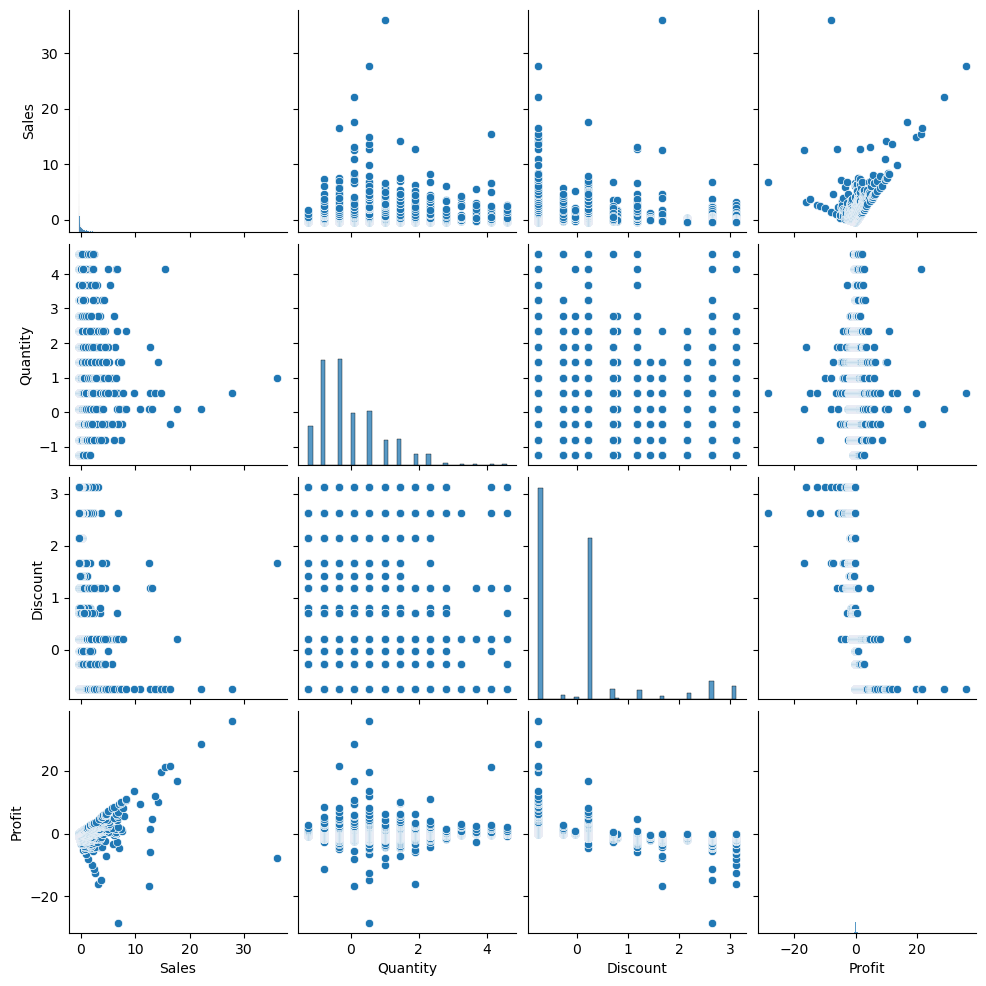

In [182]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler

#Select Numerical Features
numerical_features = ['Sales', 'Quantity', 'Discount', 'Profit']
global_super_store_numerial_data = global_super_store_data[numerical_features]

# # Min-Max Scaling, Creating DataFrame with scaled data
# scaler_minmax = MinMaxScaler()
# scaled_minmax_df = pd.DataFrame(scaler_minmax.fit_transform(global_super_store_numerial_data), columns=global_super_store_numerial_data.columns)
# print(scaled_minmax_df)
# sns.pairplot(scaled_minmax_df)

# Standard Scaling (Z-score normalization), Creating DataFrame with standardized data
scaler_std = StandardScaler()
standardized_df = pd.DataFrame(scaler_std.fit_transform(global_super_store_numerial_data), columns=global_super_store_numerial_data.columns)
print(standardized_df)
sns.pairplot(standardized_df)

# # Power Transformer, Creating DataFrame with Power Transformer data
# scaler_pwr = PowerTransformer()
# standardized_pwr_df = pd.DataFrame(scaler_pwr.fit_transform(global_super_store_numerial_data), columns=global_super_store_numerial_data.columns)
# print(standardized_pwr_df)
# sns.pairplot(standardized_pwr_df)

# # Robust Scaler, Creating DataFrame with Robust Scaler data
# scaler_rob = RobustScaler()
# standardized_rob_df = pd.DataFrame(scaler_rob.fit_transform(global_super_store_numerial_data), columns=global_super_store_numerial_data.columns)
# print(standardized_rob_df)
# sns.pairplot(standardized_rob_df)


### 2.4 Grouping of data

#### Grouping Sales/Profits based on Categories

In [139]:
global_super_store_data['Category'] = global_super_store_data['Category'].fillna('NO_CATEGORY')
global_super_store_data['Category'] = global_super_store_data['Category'].replace('Frnture', 'Furniture')
unique_categories = global_super_store_data['Category'].unique()
print(unique_categories)

['Technology' 'Office Supplies' 'Furniture' 'NO_CATEGORY']


In [140]:
# group total sales by category from the highest sale.
sales_category = global_super_store_data.groupby('Category')['Sales'].sum().sort_values(ascending=False)
sales_category

Category
Technology         836154.0330
Furniture          741827.6853
Office Supplies    718808.1040
NO_CATEGORY           238.9280
Name: Sales, dtype: float64

In [141]:
# group total profits by category
profit_category = global_super_store_data.groupby('Category')['Profit'].sum().sort_values(ascending=False)
profit_category

Category
Technology         145482.6639
Office Supplies    123953.9599
Furniture           20945.7713
NO_CATEGORY           -70.1760
Name: Profit, dtype: float64

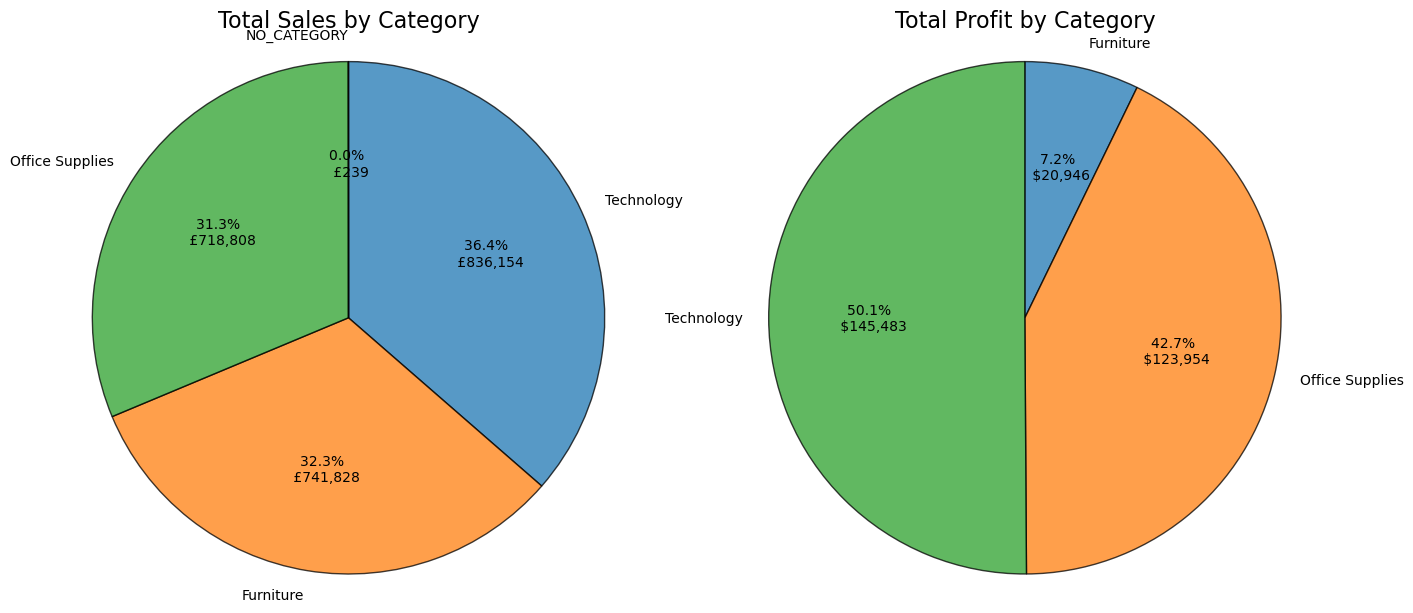

In [142]:
# group total sales by category, only considering positive sales
sales_based_on_category = global_super_store_data.groupby('Category').filter(lambda x: x['Sales'].sum() > 0).groupby('Category')['Sales'].sum()

# group total profit by category, only considering positive profits
profit_category = global_super_store_data.groupby('Category').filter(lambda x: x['Profit'].sum() > 0).groupby('Category')['Profit'].sum()

# figure size
plt.figure(figsize=(16,12));

# left total sales pie chart
plt.subplot(1,2,1); # 1 row, 2 columns, the 1st plot.
plt.pie(sales_category.values, labels=sales_category.index, startangle=90, counterclock=False,
        autopct=lambda p:f'{p:.1f}% \n £{p*np.sum(sales_category.values)/100 :,.0f}', 
        wedgeprops={'linewidth': 1, 'edgecolor':'black', 'alpha':0.75});
plt.axis('square');
plt.title('Total Sales by Category',  fontdict={'fontsize':16});

# right total profits pie chart
plt.subplot(1,2,2); # 1 row, 2 columns, the 2nd plot
plt.pie(profit_category.values, labels=profit_category.index, startangle=90, counterclock=False,
        autopct=lambda p:f'{p:.1f}% \n ${p*np.sum(profit_category.values)/100 :,.0f}',
        wedgeprops={'linewidth': 1, 'edgecolor':'black', 'alpha':0.75});
plt.axis('square');
plt.title('Total Profit by Category', fontdict={'fontsize':16});

 > _Total Sales on Categories_

1. Technology at 36.4% 
2. Furniture at 32.3%
3. Office Supplies at 31.3%

Sales depict a near-perfect symmmetery on categories, with **Technology** winning with a slight edge.

 > _Total Profits on Categories_

1. Technology at 50.1%
2. Office Supplies at 42.7%
3. Furniture at 7.2%

Profits are largely taken by **Technology** category with *Office Supplies* being the lowest.

#### Grouping Sales/Profits based on Sub-Categories

In [143]:
global_super_store_data['Sub-Category'] = global_super_store_data['Sub-Category'].fillna('NO_SUB_CATEGORY')
unique_sub_categories = global_super_store_data['Sub-Category'].unique()
print(unique_sub_categories)

print(type(unique_sub_categories))

['Machines' 'Binders' 'Tables' 'Bookcases' 'NO_SUB_CATEGORY' 'Appliances'
 'Supplies' 'Chairs' 'Furnishings' 'Phones' 'Storage' 'Accessories'
 'Fasteners' 'Art' 'Envelopes' 'Labels' 'Paper' 'Copiers']
<class 'numpy.ndarray'>


In [144]:
# group total sales by sub-category from the highest sale.
sales_sub_category = global_super_store_data.groupby(['Sub-Category'], as_index=False)['Sales'].sum().sort_values(by='Sub-Category')
print(sales_sub_category)

       Sub-Category        Sales
0       Accessories  167380.3180
1        Appliances  107532.1610
2               Art   27118.7920
3           Binders  202515.7430
4         Bookcases  114879.9963
5            Chairs  328449.1030
6           Copiers  149528.0300
7         Envelopes   16476.4020
8         Fasteners    3024.2800
9       Furnishings   91705.1640
10           Labels   12486.3120
11         Machines  189058.6400
12  NO_SUB_CATEGORY    1951.1870
13            Paper   78479.2060
14           Phones  330007.0540
15          Storage  223570.8720
16         Supplies   46673.5380
17           Tables  206191.9520


In [145]:
# group total profit by sub-category from the highest profit.
profit_sub_category = global_super_store_data.groupby(['Sub-Category'], as_index=False)['Profit'].sum().sort_values(by='Sub-Category')
print(profit_sub_category)

       Sub-Category      Profit
0       Accessories  41936.6357
1        Appliances  18190.9638
2               Art   6527.7870
3           Binders  32959.8093
4         Bookcases  -2988.0392
5            Chairs  26653.5428
6           Copiers  55617.8249
7         Envelopes   6964.1767
8         Fasteners    949.5182
9       Furnishings  13143.4364
10           Labels   5546.2540
11         Machines   3636.7443
12  NO_SUB_CATEGORY  -2097.5307
13            Paper  34053.5693
14           Phones  44543.4464
15          Storage  21390.8554
16         Supplies  -1154.3415
17           Tables -15562.4337


In [146]:
#Grouping the data on category and it's respective sub-categories. Calculating the profit margin.
sales_per_cat_subcat = global_super_store_data.groupby(['Category', 'Sub-Category'], as_index=False)[['Sales', 'Profit']].sum()
sales_per_cat_subcat['Profit Margin'] = sales_per_cat_subcat['Profit'] / sales_per_cat_subcat['Sales']

#Sorting the dataframe based on profit margin
sales_per_cat_subcat = sales_per_cat_subcat.sort_values(by=['Category', 'Sub-Category', 'Profit Margin'], ascending=True)

sales_per_cat_subcat.describe()

,Sales,Profit,Profit Margin
count,22.000000,22.000000,22.000000
mean,104410.397741,13196.009959,-0.052070
std,106716.132964,18666.445680,0.520548
min,17.904000,-15562.433700,-1.400000
25%,5389.788000,-202.804550,-0.063109
50%,85092.185000,6037.020500,0.115499
75%,183639.059500,25351.684950,0.248088
max,330007.054000,55617.824900,0.444187


### 2.7 Univariate analysis and visualisation

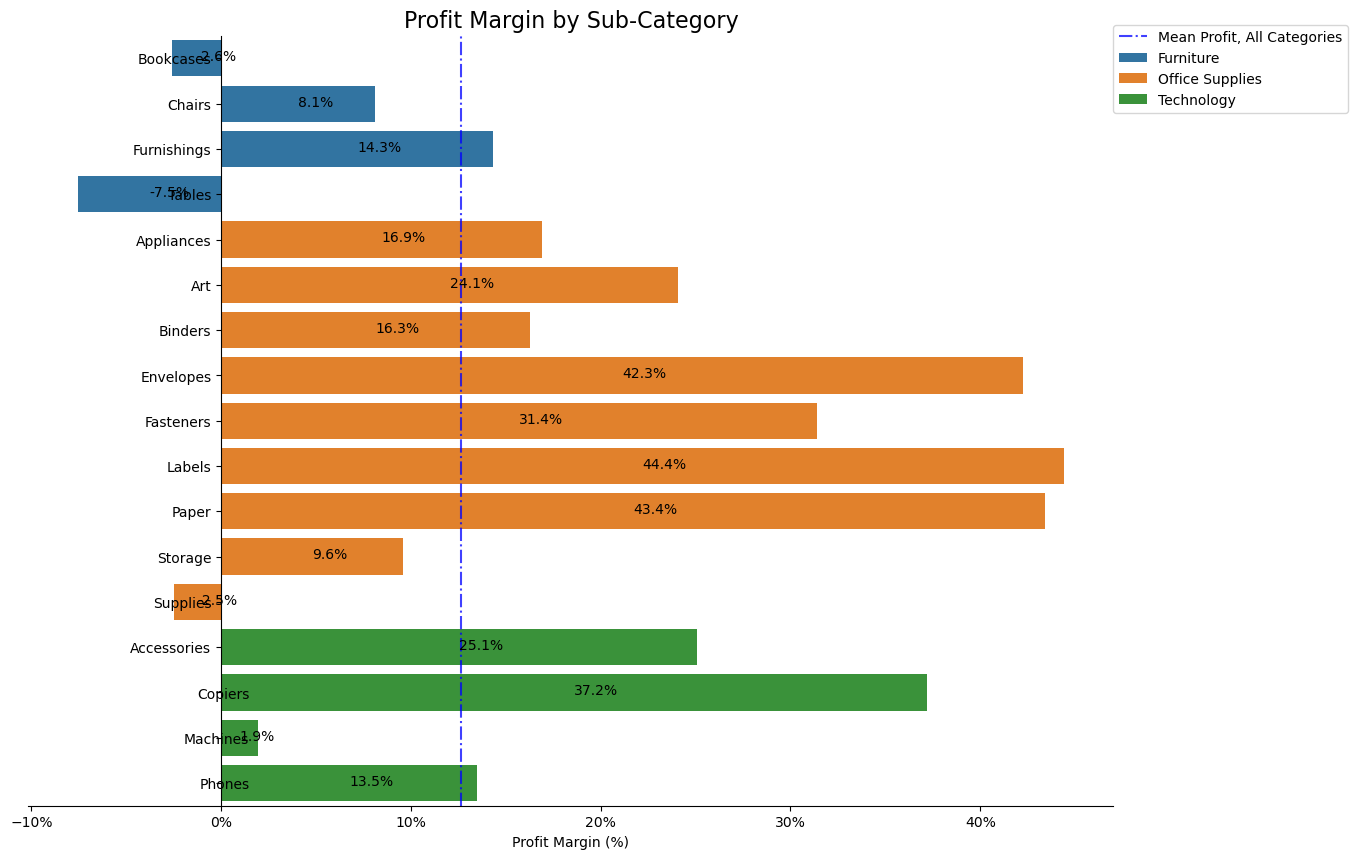

In [161]:
# Datafix on Category based on subcategories
# Apply the condition element-wise
condition = (global_super_store_data['Category'] == 'NO_CATEGORY') & \
            (global_super_store_data['Sub-Category'].isin(['Binders', 'Storage']))

# Update 'Category' where the condition is True
global_super_store_data.loc[condition, 'Category'] = 'Office Supplies'


#Grouping the data on category and it's respective sub-categories. Calculating the profit margin.
sales_per_cat_subcat = global_super_store_data.groupby(['Category', 'Sub-Category'], as_index=False)[['Sales', 'Profit']].sum()
sales_per_cat_subcat['Profit Margin'] = sales_per_cat_subcat['Profit'] / sales_per_cat_subcat['Sales']

#Sorting the dataframe based on profit margin
sales_per_cat_subcat = sales_per_cat_subcat.sort_values(by=['Category', 'Sub-Category', 'Profit Margin'], ascending=True)

# plot a profit margins sub-category bar chart 
fig, ax = plt.subplots(figsize=(14,10))

# Unique sub categories without NO_SUB_CATEGORY
unique_sub_categories_without_custom_label = sales_per_cat_subcat[sales_per_cat_subcat['Sub-Category'] != 'NO_SUB_CATEGORY']['Sub-Category'].unique()

#Plotting the profit margin per sub-category.
sns.barplot(y=sales_per_cat_subcat['Sub-Category'], x=sales_per_cat_subcat['Profit Margin'], hue=sales_per_cat_subcat['Category'], 
                alpha=1, dodge=False, ax=ax, order=unique_sub_categories_without_custom_label)

#Cleaning out bar junk
ax.spines['left'].set_position('zero')
ax.spines[['right','top']].set_visible(False)
ax.set(ylabel=None, xlabel='Profit Margin (%)')

def move_ylabel_tick(index: list):
    """
    Moving the provided ylabel ticks
    """
    for tick in index:
        ax.get_yticklabels()[tick].set_x(0.02)
        ax.get_yticklabels()[tick].set_horizontalalignment('right')

#Moving the y-labels on sub-categories that are making a loss in order to prevent collision of the bar and the text.
move_ylabel_tick([-1, -2, -3])


#Annotating the profit margin amount for each bar.
for p in ax.patches:
    _, y = p.get_xy()
    
    ax.annotate(f'{p.get_width()*100 :.1f}%', (p.get_width() / 2, y + 0.45))
    
#Calculating Superstore's aggregate profit margin in order to compare it to each sub-category's profit margin
mean_profit = sales_per_cat_subcat['Profit'].sum() / sales_per_cat_subcat['Sales'].sum()

#Plotting a vertical line and annotating the Superstore's aggregate profit margin.
ax.axvline(mean_profit, color='blue', label='Mean Profit, All Categories', alpha=0.75, ls='-.')

#Setting the title and legend.
ax.set_title('Profit Margin by Sub-Category', fontdict={'fontsize':16})
ax.legend(loc=(1, 0.9))

#Formatting the x-axis as %
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

### 2.5 Handling missing values in the dataset

### 2.6 Correlation 

In [ ]:
correlation_matrix = global_super_store_numerial_data.corr()
correlation_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix as heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


In [ ]:
columns_to_describe['Profit'] = columns_to_describe['Profit'].str.replace('"','')
columns_to_describe['Profit'] = columns_to_describe['Profit'].fillna(0)
columns_to_describe

In [ ]:
columns_to_describe.describe()
columns_to_describe.info()

In [ ]:
columns_to_describe['Profit'] = columns_to_describe['Profit'].apply(text2float)
columns_to_describe

In [ ]:
columns_to_describe.describe()

In [ ]:
columns_to_describe.info()

In [ ]:
columns_to_describe['Transformed'] = np.log1p(columns_to_describe['Sales'])
print("Original data:")
columns_to_describe

In [ ]:
ss_data.describe()

In [ ]:
ss_data['Profit'] = ss_data['Profit'].str.replace('"', '')

In [ ]:
ss_data['Quantity'] = ss_data['Quantity'].str.replace('?', '')

In [ ]:
ss_data['Quantity'] = ss_data['Quantity'].apply(text2float)

In [ ]:
ss_data.describe()

In [ ]:
ss_data['Postal Code'] = ss_data['Postal Code'].str.replace('"', '')

In [ ]:
ss_data['Country'] = ss_data['Country'].str.replace('US', 'United States')

In [ ]:
ss_data.to_csv('10042024.csv')

In [ ]:
ss_data['State'] = ss_data['State'].dropna()
us_states = ss_data['State'].unique()

print(us_states)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

In [ ]:
sns.pairplot(ss_data)

In [ ]:
ss_data['Category'] = ss_data['Category'].str.replace('Frnture', 'Furniture')

In [ ]:
sns.pairplot(ss_data)

In [ ]:
ss_data.groupby('State').size()

In [ ]:
sns.lmplot(data=ss_data, x='Sales', y='Quantity', hue='Category')